# Kaggle Digit Recognition Competition with PyTorch

In [43]:
#import necessary modules
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
from torchvision import datasets, transforms

## Loading and Splitting csv data
Here we divided traning data into two random sub-sets into 8:2 portion.80% data belongs to training_data subset and 20% data belongs to validiation data subset. 

In [52]:
#This unit splits training data into train and validation set
inputdata=pd.read_csv('train.csv')
#Generate Random Number for creating training and validation set
msk=np.random.rand(len(inputdata))<=0.8
traindata=inputdata[msk]
valdata=inputdata[~msk]

testdata=pd.read_csv('test.csv')

print(traindata.shape)
print(valdata.shape)
print(testdata.shape)

(33699, 785)
(8301, 785)
(28000, 784)


## Preparing Data for Neural Network Input

In [13]:
#This segment prepares dataset for training and testing purposes

class CustomedDataset(torch.utils.data.Dataset):
    def __init__(self,data,train=True):#__init__ is the constructor for the class,self is the instance of the object
        self.train = train         #helpful for setting initial values for certain member variables.
        if self.train :
            trainX = data
            trainY = trainX.label.as_matrix().tolist()
            trainX = trainX.drop('label',axis=1).as_matrix().reshape(trainX.shape[0], 1,28, 28)
            self.datalist = trainX
            self.labellist = trainY
        else:
            testX = data
            testX = testX.as_matrix().reshape(testX.shape[0], 1, 28, 28)
            self.datalist = testX
            
    def __getitem__(self, index):
        if self.train:
            return torch.Tensor(self.datalist[index].astype(float)),self.labellist[index]
        else:
            return torch.Tensor(self.datalist[index].astype(float))
    
    def __len__(self):
        return self.datalist.shape[0]


## Loading data into Pytorch Dataloder

In [35]:

train_data=CustomedDataset(traindata)
val_data=CustomedDataset(valdata)
test_data=CustomedDataset(testdata,train=False)

#Loading training data
#Here pytorch format is torch.utils.data.DataLoader([features,labels],batch_size,suffle)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valloader=torch.utils.data.DataLoader(val_data,batch_size=64,shuffle=False)
testloader=torch.utils.data.DataLoader(dataset=test_data,batch_size=64,shuffle=False)



/home/heliobreaker/anaconda3/envs/Essentials/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/heliobreaker/anaconda3/envs/Essentials/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/home/heliobreaker/anaconda3/envs/Essentials/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


## Creating Neural Network

Here we have created multilayered Perceptron Network.To prevent overfitting we have added a dropout layer with 30%
probability of dropping out of neurons in each of the 3 hidden layer.Also ,to prevent underfitting problem we have
used log_softmax  function in the output layer as our activation function.This function returns us the probability 
of each class:<br>
                                  **log(exp(x_i) / exp(x).sum())**
        

In [2]:
from torch import nn,optim
import torch.nn.functional as F

#Making a neural Network model
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(784,256)
        self.fc2=nn.Linear(256,128)
        self.fc3=nn.Linear(128,64)
        self.fc4=nn.Linear(64,10)
     
        #intializing dropout layer
        self.dropout=nn.Dropout(p=0.3)
    
    def forward(self,x):
        #We used dropout layers to prevent overfitting
        h1=self.dropout(F.relu(self.fc1(x)))
        h2=self.dropout(F.relu(self.fc2(h1)))
        h3=self.dropout(F.relu(self.fc3(h2)))
        #Here Logsoftmax layer is used to prevent underflow.
        out=F.log_softmax(self.fc4(h3),dim=1)
        
        return out

## Training and validiating our Neural Network

For Training our network we have used Negative Log Likelihood as out loss function because it helps us to find 
logarithmic loss at each output node as well as to converge network quickly we have also implemented Adam 
optimization technique.

In [68]:
#Training Model

model=Network()
criterion=nn.NLLLoss()
optimizer=optim.Adam(model.parameters(),lr=0.003)

epochs=50
steps=0

train_losses,val_losses=[],[]

for e in range(epochs):
    running_loss=0
    val_loss=0
    accuracy=0
    
    for images,labels in trainloader:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        logits=model(images)
        loss=criterion(logits,labels)
        loss.backward()
        optimizer.step()
        
        running_loss+=loss.item()
    else:
        with torch.no_grad():
            model.eval() #model is now turned into evaluation mode
            for images,labels in valloader:
                images = images.view(images.shape[0], -1)
                logits=model(images)
                val_loss+=criterion(logits,labels)
            
                ps=torch.exp(logits)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        model.train() #training mode
        train_losses.append(running_loss/len(trainloader))
        val_losses.append(val_loss/len(valloader))

    print("Epoch: {}/{}.. ".format(e+1, epochs),
        "Training Loss: {:.3f}.. ".format(train_losses[-1]),
        "Validation Loss: {:.3f}.. ".format(val_losses[-1]),
        "Validation Accuracy: {:.3f}".format(accuracy/len(valloader)))           



Epoch: 1/50..  Training Loss: 0.758..  Validation Loss: 0.316..  Validation Accuracy: 0.916
Epoch: 2/50..  Training Loss: 0.468..  Validation Loss: 0.256..  Validation Accuracy: 0.933
Epoch: 3/50..  Training Loss: 0.449..  Validation Loss: 0.307..  Validation Accuracy: 0.927
Epoch: 4/50..  Training Loss: 0.458..  Validation Loss: 0.258..  Validation Accuracy: 0.940
Epoch: 5/50..  Training Loss: 0.443..  Validation Loss: 0.298..  Validation Accuracy: 0.928
Epoch: 6/50..  Training Loss: 0.432..  Validation Loss: 0.306..  Validation Accuracy: 0.933
Epoch: 7/50..  Training Loss: 0.436..  Validation Loss: 0.315..  Validation Accuracy: 0.937
Epoch: 8/50..  Training Loss: 0.404..  Validation Loss: 0.249..  Validation Accuracy: 0.942
Epoch: 9/50..  Training Loss: 0.378..  Validation Loss: 0.269..  Validation Accuracy: 0.938
Epoch: 10/50..  Training Loss: 0.435..  Validation Loss: 0.270..  Validation Accuracy: 0.936
Epoch: 11/50..  Training Loss: 0.404..  Validation Loss: 0.292..  Validation Ac

## Now we visualize the losses in Training and Validiation Set


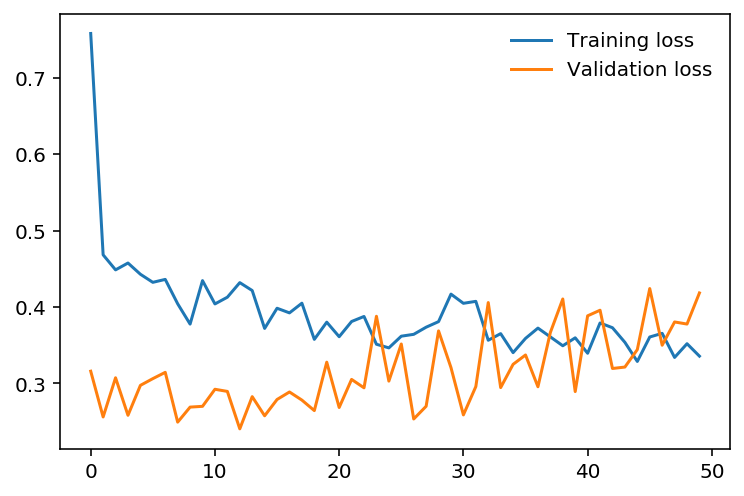

In [69]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

## Labelling Test Data

In [71]:
model.eval()
prediction=torch.LongTensor()
for images in testloader:
    images = images.view(images.shape[0], -1)
    logits=model(images)
    ps=torch.exp(logits)
    _,pred=torch.max(ps.data,1)
    prediction=torch.cat((prediction,pred),0)
prediction=prediction.numpy()

ans=pd.DataFrame(prediction)
ans.columns=['Label']
Id=range(1,ans.size+1)
ans.insert(0,'ImageId',Id)

ans.head()

ans.to_csv('submit_pytorch.csv',index=False)